<a href="https://colab.research.google.com/github/reinaldoasf/COVID-19/blob/master/Paulo_Separador_Train_Test_das_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Separando Conjuntos de Teste e Treino

Neste notebook terá o código necessário para ler as imagens do dataset de raios X do pulmão.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)
%cd /gdrive/My\ Drive/Kaggle

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/Kaggle


In [ ]:
!ls COVID-19/

 COVID-19		  NORMAL.metadata.xlsx	'Viral Pneumonia.matadata.xlsx'
 COVID-19.metadata.xlsx   README.md.txt
 NORMAL			 'Viral Pneumonia'


In [ ]:


import cv2
import os, glob
from PIL import Image, ImageOps
import numpy as np
import seaborn as sns; sns.set(style="whitegrid")
from imutils import paths
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras.layers import Input, Dense, Flatten, AveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPool2D



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
LR = 0.001
EPOCHS = 20
BATCH_SIZE = 32
COVID_LEN = len(glob.glob("COVID-19/COVID-19/*"))
INP_SIZE = (224,224,3)
def create_data(dir_name):
    temp_data = []
    img_list = glob.glob(dir_name + '/*')
    for img in img_list:
        image = Image.open(img).resize((64, 64))#Tive que mudar o tamanho pq tava estourando a memória RAM do Colab
        image = ImageOps.grayscale(image=image)
        image = np.array(image)
        temp_data.append(image)
    return temp_data

data = []
labels = []

covid_dir = 'COVID-19/COVID-19'
normal_dir = 'COVID-19/NORMAL'
# pneumonia_dir = 'input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia'

data.extend(create_data(covid_dir))
data.extend(create_data(normal_dir))
# data.extend(create_data(pneumonia_dir))





In [ ]:
# data = np.array(data)/255.0
labels = [1 if i < COVID_LEN else 0 for i in range(len(data))]
labels_array = np.array(labels)
data_array = np.array(data)
print(data_array.shape)
print(labels_array.shape)

(1560, 64, 64)
(1560,)


In [ ]:
lb = LabelBinarizer()
labels_array = lb.fit_transform(labels_array)
labels_array = to_categorical(labels)

(x_images_train, x_images_test, y_labels_train, y_labels_test) = train_test_split(
    data_array,
    labels_array,
    test_size=0.25,
    stratify=labels_array,
    random_state=42
)
(x_images_train, x_images_test, y_labels_train, y_labels_test) = train_test_split(
    data_array,
    labels_array,
    test_size=0.30,
    stratify=labels_array,
    random_state=42
)
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest"
)

# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)


In [ ]:
len(data)

1560

# TSNE Plot
 Aqui será feita uma visualização do conjunto de dados para uma visualização em 2D da distribuição dos dados com o TSNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=50, n_iter=300, n_iter_without_progress=100)

x_flattened = np.array(list(map(lambda x: x.flatten(), data)))
print(x_flattened.shape)

(1560, 65536)


Iniciando t-SNE...
t-SNE finalizado, plotando gráfico da distribuição...


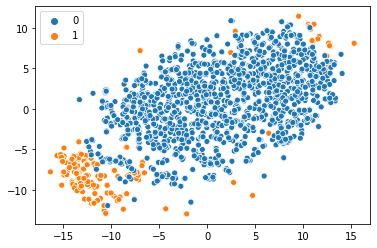

In [ ]:
print("Iniciando t-SNE...")
x_embedded = tsne.fit_transform(x_flattened)
print("t-SNE finalizado, plotando gráfico da distribuição...")
sns.scatterplot(x_embedded[:, 0], x_embedded[:, 1], hue=labels, )


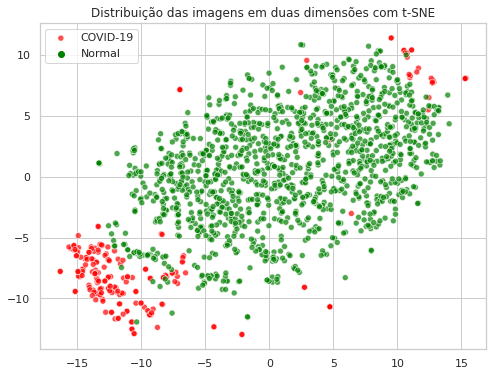

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x_embedded[:, 0], x_embedded[:, 1], hue=labels, alpha=0.7, palette=["green", "red"])
plt.title("Distribuição das imagens em duas dimensões com t-SNE")
plt.legend(["COVID-19", "Normal"])

# Treinando o modelo de Deep Learning

In [ ]:
x_images_train, x_images_test = x_images_train / 255.0, x_images_test / 255.0

# Acrescentar 'uma dimensão' no X 
x_train_reshape = x_images_train
x_test_reshape = x_images_test
x_train_reshape = x_train_reshape.reshape(list(x_train_reshape.shape) + [1]) 
x_test_reshape  = x_test_reshape.reshape(list(x_test_reshape.shape) + [1]) 

In [ ]:
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

input_shape=(64, 64, 1)
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))
model.add(Conv2D(16, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(1, 1), strides=(2, 2), padding="valid"))
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy",],)
model.fit(x_train_reshape, y_labels_train, epochs=50, batch_size=10, verbose=1)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
Epoch 1/50
110/110 [==============================] - 1s 9ms/step - loss: 0.3320 - accuracy: 0.8727
Epoch 2/50
110/110 [==============================] - 1s 8ms/step - loss: 0.1162 - accuracy: 0.9652
Epoch 3/50
110/110 [==============================] - 1s 8ms/step - loss: 0.0814 - accuracy: 0.9707
Epoch 4/50
110/110 [==============================] - 1s 8ms/step - loss: 0.0679 - accuracy: 0.9753
Epoch 5/50
110/110 [==============================] - 1s 8ms/step - loss: 0.0756 - accuracy: 0.9698
Epoch 6/50
110/110 [==============================] - 1s 8ms/step - loss: 0.0630 - accuracy: 0.9716
Epoch 7/50
110/110 [==============================] - 1s 8ms/step - loss: 0.0482 - accuracy: 0.9817
Epoch 8/50
110/110 [==============================] - 1s 7ms/step - loss: 0.0342 - accuracy: 0.9853
Epoch 9/50
110/110 [==============================] - 1s 7ms/step - loss: 0.0

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

## Avaliação do modelo

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(model.predict(x_test_reshape), axis=1)
print(classification_report(y_labels_test[:, 1], y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.988     0.990     0.989       402
         1.0      0.938     0.924     0.931        66

    accuracy                          0.981       468
   macro avg      0.963     0.957     0.960       468
weighted avg      0.981     0.981     0.981       468



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_train = np.argmax(model.predict(x_train_reshape), axis=1)
print(classification_report(y_labels_train[:, 1], y_pred_train, digits=3))

              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000       939
         1.0      1.000     1.000     1.000       153

    accuracy                          1.000      1092
   macro avg      1.000     1.000     1.000      1092
weighted avg      1.000     1.000     1.000      1092



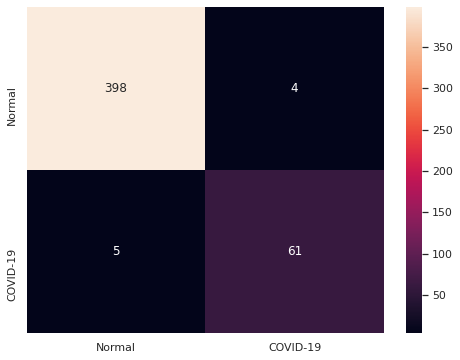

In [ ]:
conf_matrix = confusion_matrix(y_labels_test[:, 1], y_pred)#, labels=["Normal", "COVID-19"])
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, fmt=".0f", annot=True)
ax.set_yticklabels(["Normal", "COVID-19"])
ax.set_xticklabels(["Normal", "COVID-19"])
plt.show()

In [ ]:
type(y_labels_test[:, 1])

numpy.ndarray

In [ ]:
type(y_pred)

numpy.ndarray

# Incluindo mais uma classe

In [ ]:
covid_dir = 'COVID-19/COVID-19'
normal_dir = 'COVID-19/NORMAL'
pneumonia_dir = 'COVID-19/Viral Pneumonia'
# pneumonia_dir = 'input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia'

def create_data(dir_name):
    temp_data = []
    img_list = glob.glob(dir_name + '/*')
    for img in img_list:
        image = Image.open(img).resize((64, 64))#Tive que mudar o tamanho pq tava estourando a memória RAM do Colab
        image = ImageOps.grayscale(image=image)
        image = np.array(image)
        temp_data.append(image)
    return temp_data

data = []
labels = []
data.extend(create_data(covid_dir))
COVID_LEN = len(data)
data.extend(create_data(normal_dir))
normal_len = len(data)
data.extend(create_data(pneumonia_dir))

labels = []
for i in range(len(data)):
  if i < COVID_LEN:
    labels.append(0) 
  elif i < normal_len:
    labels.append(1)
  else:
    labels.append(2) 


In [ ]:
labels_array = np.array(labels)
data_array = np.array(data)
lb = OneHotEncoder()
labels_array = lb.fit_transform(labels_array.reshape(-1, 1))
# labels_array = to_categorical(labels)

(x_images_train, x_images_test, y_labels_train, y_labels_test) = train_test_split(
    data_array,
    labels_array,
    test_size=0.25,
    # stratify=labels_array,
    random_state=42
)
(x_images_train, x_images_test, y_labels_train, y_labels_test) = train_test_split(
    data_array,
    labels_array,
    test_size=0.30,
    # stratify=labels_array,
    random_state=42
)
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest"
)

# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)


ValueError: ignored

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=50, n_iter=300, n_iter_without_progress=100)

x_flattened = np.array(list(map(lambda x: x.flatten(), data)))
print(x_flattened.shape)

(2905, 4096)


In [ ]:
print("Iniciando t-SNE...")
x_embedded = tsne.fit_transform(x_flattened)
print("t-SNE finalizado, plotando gráfico da distribuição...")



Iniciando t-SNE...
t-SNE finalizado, plotando gráfico da distribuição...


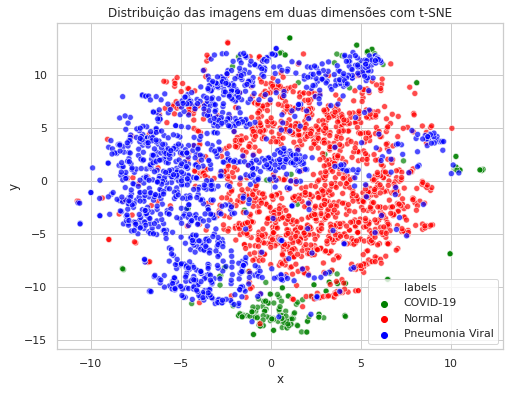

In [ ]:
import pandas as pd
three_classes_df = pd.DataFrame(dict(x=x_embedded[:, 0], y=x_embedded[:, 1], labels=labels))
three_classes_df["labels"] = three_classes_df["labels"].replace([0, 1, 2], ["COVID-19", "Normal", "Pneumonia Viral"])
plt.figure(figsize=(8, 6))
sns.scatterplot("x", "y", hue="labels", data=three_classes_df, palette=["green", "red", "blue"], legend="full", alpha=0.7)
plt.title("Distribuição das imagens em duas dimensões com t-SNE")
plt.legend(loc="best")
plt.show()

In [ ]:
set(labels)

{0, 1, 2}

In [ ]:
x_images_train, x_images_test = x_images_train / 255.0, x_images_test / 255.0

# Acrescentar 'uma dimensão' no X 
x_train_reshape = x_images_train
x_test_reshape = x_images_test
x_train_reshape = x_train_reshape.reshape(list(x_train_reshape.shape) + [1]) 
x_test_reshape  = x_test_reshape.reshape(list(x_test_reshape.shape) + [1]) 

In [ ]:
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

input_shape=(64, 64, 1)
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))
model.add(Conv2D(16, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(1, 1), strides=(2, 2), padding="valid"))
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy",],)
model.fit(x_train_reshape, y_labels_train.to_tensor, epochs=50, batch_size=10, verbose=1)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
Epoch 1/50


TypeError: ignored

In [ ]:
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(x_test_reshape), axis=1)
print(classification_report(y_labels_test[:, 1], y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.578     0.551     0.564       938
         1.0      0.423     0.055     0.097       402
         2.0      0.000     0.000     0.000         0

    accuracy                          0.402      1340
   macro avg      0.334     0.202     0.220      1340
weighted avg      0.531     0.402     0.424      1340



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
